In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import tqdm
tqdm.tqdm.pandas()

In [3]:
import pandas as pd
import geopandas as gpd
import utm
from haversine import haversine

In [4]:
DATA_DIR = pathlib.Path("../../data/")

# Loading data

In [5]:
locations = pd.read_csv(DATA_DIR.joinpath("locations.csv"), header=None)

In [6]:
locations.head()

,0,1
0,42.63914,141.62366
1,36.42835,140.61340
2,42.63864,141.62542
3,36.42911,140.61360
4,36.42957,140.61429


In [7]:
locations.columns = ["lat", "lon"]

In [8]:
locations.max()

lat     78.93490
lon    179.82728
dtype: float64

In [9]:
locations.min()

lat    -54.81624
lon   -179.11254
dtype: float64

(just a check that columns are in the correct order)

In [10]:
def get_utm(lat, lon):
    """Calculate UTM coordinates latitude and longitude."""

    easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)
    return pd.Series([easting, northing, zone_number, zone_letter],
                     index=["easting", "northing", "zone_number", "zone_letter"])

if not DATA_DIR.joinpath("locations_utm.csv").exists():
    locations_utm = locations.progress_apply(lambda row: get_utm(row.lat, row.lon), axis=1)
    locations_utm.to_csv(DATA_DIR.joinpath("locations_utm.csv"), index=False)
else:
    locations_utm = pd.read_csv(DATA_DIR.joinpath("locations_utm.csv"))

In [11]:
locations_utm.head()

,easting,northing,zone_number,zone_letter
0,551130.048588,4.720932e+06,54,T
1,465345.985460,4.031530e+06,54,S
2,551274.751185,4.720877e+06,54,T
3,465364.250731,4.031614e+06,54,S
4,465426.304542,4.031665e+06,54,S


In [12]:
locations_utm = locations_utm.join(locations)

# KDTree test

In [87]:
from scipy.spatial import KDTree, cKDTree

In [17]:
locations_utm.groupby(["zone_number", "zone_letter"]).size().sort_values(ascending=False).head(15)

zone_number  zone_letter
53           S              126697
31           U              119785
52           S              112220
48           N               79188
54           S               65530
51           R               62550
35           T               37867
32           U               37064
50           S               36846
32           V               32659
40           R               29545
49           Q               29537
51           S               23475
47           P               21134
50           Q               21067
dtype: int64

In [40]:
locations_utm.loc[(locations_utm.zone_number==51) & (locations_utm.zone_letter=="R")]

,easting,northing,zone_number,zone_letter,lat,lon
1679,336357.225839,3.396546e+06,51,R,30.69048,121.29147
1680,378783.788119,3.317452e+06,51,R,29.98197,121.74347
1681,352053.701584,3.405006e+06,51,R,30.76885,121.45408
1682,379270.911747,3.316732e+06,51,R,29.97552,121.74860
1683,351689.212144,3.404609e+06,51,R,30.76522,121.45033
...,...,...,...,...,...,...
1493958,398966.161040,3.328079e+06,51,R,30.07969,121.95164
1493970,353237.184413,3.443413e+06,51,R,31.11543,121.46090
1493971,417161.322810,3.337405e+06,51,R,30.16521,122.13969
1493972,270158.336548,3.542671e+06,51,R,31.99683,120.56707


In [26]:
def get_in_zone_distances(loc, locs):
    """Calculate distances between `loc` and all location in `locs` in the same zone."""
    return np.sqrt(np.square(locs[["easting", "northing"]] - loc[["easting", "northing"]]).sum(axis=1))


def get_cross_zone_distances(loc, locs):
    """Calculate distances between `loc` and all location in `locs` in the same zone."""

    dphi_sqr = np.square(locs["lat"] - loc["lat"])
    dlambda_sqr = np.square(locs["lon"] - loc["lon"])
    return R * np.sqrt(dphi_sqr + np.cos(loc.lat * np.pi / 180) * dlambda_sqr) * np.pi / 180


def get_in_zone_neighbors(loc, locs, thr):
    """Calculate neighbors of `loc` in the same zone."""
    # TODO: vectorize

    zone_mask = (locs.zone_number==loc.zone_number) & (locs.zone_letter==loc.zone_letter)
    cand_mask_x = (locs.cell_x==loc.cell_x) | (locs.cell_x==(loc.cell_x-1)) | (locs.cell_x==(loc.cell_x+1))
    cand_mask_y = (locs.cell_y==loc.cell_y) | (locs.cell_y==(loc.cell_y-1)) | (locs.cell_y==(loc.cell_y+1))
    cand_mask = cand_mask_x & cand_mask_y & zone_mask & (locs.component==-1)
    candidates = locs[cand_mask]

    dist = get_in_zone_distances(loc, candidates)
    return candidates[dist<=thr]


def get_cross_zone_neighbors(loc, locs, thr):
    """Calculate neighbors of `loc` in the same zone."""

    border_status = loc[["N", "E", "S", "W"]]
    border_list = border_status[border_status!=0].index.tolist()
    neigboring_zones = get_neighboring_zones(loc.zone_number, loc.zone_letter, border_list)

    neighbors = []

    for (zn, zl), borders in neigboring_zones.items():
        zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)
        border_mask = locs[borders].sum(axis=1)!=0
        candidates = locs[zone_mask & border_mask & (locs.component==-1)]

        dist = get_cross_zone_distances(loc, candidates)
        neighbors.append(candidates[dist<=thr])

    return pd.concat(neighbors)


class ConnectedComponent(object):
    """Connected component entity. New elements can be added, and component can check if it's finished."""
    def __init__(self, cid, all_locations, thr):
        self.members = set()
        self.visited = set()
        self.cid = cid
        self.all_locations = all_locations
        self.thr = thr

    def add(self, element):
        self.members.add(element)

    def visit(self, element):
        if element not in self.members:
            raise ValueError(f"element {element} is not in this component")
        self.visited.add(element)

    def is_full(self):
        return self.members==self.visited

    def grow(self, locs=None):
        """Grow this component by elements from `locs`."""

        subset = self.members.difference(self.visited)
        locs = locs if locs is not None else self.all_locations

        for element in subset:
            # TODO: filter by degree
            neighbors = get_in_zone_neighbors(self.all_locations.loc[element], locs, self.thr)

            if self.all_locations.loc[element, "border"]:
                cross_zone_neighbors = get_cross_zone_neighbors(self.all_locations.loc[element], locs, self.thr)
                neighbors = pd.concat([neighbors, cross_zone_neighbors])

            self.members.update(neighbors.index)
            self.visited.add(element)

    @property
    def elements(self):
        return list(self.members)

    @property
    def size(self):
        return len(self.members)

In [29]:
THR = 10000
locs = locations_utm.copy()
locs["component"] = -1
locs["cell_x"] = (locs["easting"] / THR).astype(int)
locs["cell_y"] = (locs["northing"] / THR).astype(int)

In [42]:
get_in_zone_neighbors(locs.loc[1680], locs, THR)

,easting,northing,zone_number,zone_letter,lat,lon,component,cell_x,cell_y
1680,378783.788119,3.317452e+06,51,R,29.98197,121.74347,-1,37,331
1682,379270.911747,3.316732e+06,51,R,29.97552,121.74860,-1,37,331
1684,378903.862309,3.317579e+06,51,R,29.98313,121.74470,-1,37,331
1690,378967.816227,3.317428e+06,51,R,29.98177,121.74538,-1,37,331
1698,380539.136363,3.316937e+06,51,R,29.97750,121.76172,-1,38,331
...,...,...,...,...,...,...,...,...,...
1483076,383119.677739,3.316149e+06,51,R,29.97064,121.78855,-1,38,331
1483118,386101.963008,3.314607e+06,51,R,29.95700,121.81962,-1,38,331
1486882,386664.396429,3.314585e+06,51,R,29.95686,121.82545,-1,38,331
1490941,387883.308805,3.313441e+06,51,R,29.94665,121.83820,-1,38,331


In [90]:
tree = cKDTree(locations_utm.loc[(locations_utm.zone_number==51) & (locations_utm.zone_letter=="R"),
                                 ["easting", "northing"]])

In [88]:
%%timeit
cKDTree(locations_utm.loc[(locations_utm.zone_number==51) & (locations_utm.zone_letter=="R"),
                         ["easting", "northing"]])

105 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [85]:
sample_loc = locs.loc[1680]

cand_mask_x = (locs.cell_x==sample_loc.cell_x) | (locs.cell_x==(sample_loc.cell_x-1)) | (locs.cell_x==(sample_loc.cell_x+1))
cand_mask_y = (locs.cell_y==sample_loc.cell_y) | (locs.cell_y==(sample_loc.cell_y-1)) | (locs.cell_y==(sample_loc.cell_y+1))
cand_mask = cand_mask_x & cand_mask_y


In [89]:
%%timeit
cKDTree(locs.loc[(locations_utm.zone_number==51) & (locations_utm.zone_letter=="R") & cand_mask,
                ["easting", "northing"]])

78.1 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
neighbors = tree.query_ball_point(locations_utm.loc[1680, ["easting", "northing"]], THR)
len(neighbors)

2253

In [91]:
%timeit get_in_zone_neighbors(locs.loc[1680], locs, THR)

88.1 ms ± 344 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [92]:
%timeit tree.query_ball_point(locations_utm.loc[1680, ["easting", "northing"]], THR)

650 µs ± 4.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [45]:
zone_grp = locations_utm.groupby(["zone_number", "zone_letter"])

In [51]:
len(zone_grp.groups)

437

In [95]:
kdtrees = {}

for zone, zone_locations in tqdm.tqdm(zone_grp, total=len(zone_grp.groups)):
    zn, zl = zone
    zone_mask = (locations_utm.zone_number==zn) & (locations_utm.zone_letter==zl)
    tree = cKDTree(locations_utm.loc[zone_mask, ["easting", "northing"]].values)
    kdtrees[zone] = [locations_utm.loc[zone_mask].index, tree]

100%|██████████| 437/437 [00:36<00:00, 12.13it/s]


In [53]:
kdtrees[(31, "S")]

[Int64Index([   1023,    1029,    1034,    1040,    1045,    1052,    1057,
                1064,    1070,    1077,
             ...
             1468859, 1468860, 1468975, 1470659, 1472464, 1473394, 1475540,
             1476525, 1482335, 1484627],
            dtype='int64', length=1927),

# Vectorized vs. non-vectorized version

In [70]:
sample_locs = locations_utm.loc[(locations_utm.zone_number==51) & (locations_utm.zone_letter=="R")].index[:1000]

In [93]:
%timeit tree.query_ball_point(locations_utm.loc[sample_locs, ["easting", "northing"]], THR)

299 ms ± 904 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [94]:
%%time

for loc in sample_locs:
    tree.query_ball_point(locations_utm.loc[loc, ["easting", "northing"]], THR)

CPU times: user 663 ms, sys: 0 ns, total: 663 ms
Wall time: 660 ms


Strangely, "vectorized" (i.e. fetching multiple locations at once) version is almost as slow as a plain loop.

The hierarchy is the following:
- single location query to a built tree (`~15ms`),
- building a tree for candidates (`~85ms`),
- old `get_in_zone_neighbors` for a single location (`~100ms`),
- building a tree for entire zone (`~300ms`).

Hence, we cannot build a new tree for each location (it's `15ms + 85ms` or about the same as `get_in_zone_neighbors`). The only option is to maintain full zone tree (for unmarked locations only) and rebuild it after each growth iteration.

In [99]:
locations_utm["zone"].value_counts().head(20)

53S    126697
31U    119785
52S    112220
48N     79188
54S     65530
51R     62550
35T     37867
32U     37064
50S     36846
32V     32659
40R     29545
49Q     29537
51S     23475
47P     21134
50Q     21067
30U     21034
37T     19846
30S     18349
39R     16967
51P     16269
Name: zone, dtype: int64

In [ ]:
locations_utm.groupby(["zone_number", "zone_letter"])

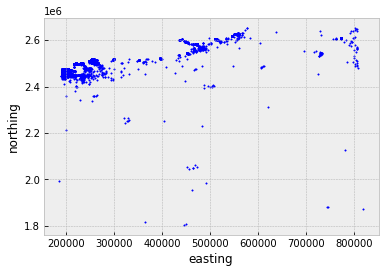

In [106]:
locations_utm[(locations_utm.zone_number==50) & (locations_utm.zone_letter=="Q")].plot(x="easting", y="northing", s=2, kind="scatter")